# Assignment 4
## Short answer questions:
(Write a short one or two sentence answer to each of the questions below. Make sure your answer is clear and concise)
1.	Please briefly explain PCA and NMF, and describe their similarities and differences. (2 points)
2.	Please explain why the initialization process of weights and bias is important for neural networks. (1 point)
3.	How would you prevent overfitting when designing an artificial neural network? (1 point)
4.  Please describe the key differences between convolutional neural network and multilayer perceptron? (1 point)
5.	What is the “vanishing gradient” problem with neural networks based on sigmoid non-linearities? (1 point)


## Coding question
### LeNet-5 CIFAR10 Classifier

This notebook implements the classic LeNet-5 convolutional network. Please modify the code and train LeNet-5 on the CIFAR10 dataset for classification. The basic architecture is shown in the lecture slides.

LeNet-5 is commonly regarded as the pioneer of convolutional neural networks, consisting of a simple architecture (by modern standards). In total, LeNet-5 consists of only 5 learnable layers. 3 out of these layers are convolutional layers (C1, C3, C5), which are connected by two average pooling layers (S2 & S4). The penultimate layer is a fully connexted layer (F6), which is followed by the final output layer.

**The goal of this assignment is to try various techniques to improve the performance to over 80% accuracy. 

You are expected to use Google Colab and Pytorch on this assignment.
 
1.	Please summarize the modification you did to improve the performance (2pts)
2.	Report the test accuracy, and provide the experiment logging record for your best model. (2 pts)

Tips: When using Google Colab, please use the free TPU to accelerate the model training. Otherwise, it may take hours to finish the model training.
Specifically, please click 'change runtime type' from the 'Runtime' and change from CPU (default) to any available GPU options. 


Turning it in:
Submit the assignment on Canvas. Be sure to include your names. Submit a PDF version of the notebook as well as a runnable copy of the notebook.


## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [2]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 100

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

### CIFAR-10 Dataset

In [3]:
##########################
### CIFAR-10 Dataset
##########################

train_mean = (0.5, 0.5, 0.5)
train_std = (0.5, 0.5, 0.5)

# resize_transform = transforms.Compose([transforms.Resize((32, 32)),
#                                         transforms.RandomCrop(32, padding=4),
#                                         transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize(train_mean, train_std)])

resize_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])
##add augmentations
# aug_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(train_mean, train_std)
# ])
# resize_transform = aug_transform
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=resize_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


In [4]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [5]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 128, kernel_size=5, padding=2),  # Output: 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Output: 128x1x1
            nn.Flatten(), 
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        # x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

In [6]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)



## Training

In [7]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 0000/0391 | Cost: 2.2988
Epoch: 001/100 | Batch 0050/0391 | Cost: 1.7833
Epoch: 001/100 | Batch 0100/0391 | Cost: 1.6838
Epoch: 001/100 | Batch 0150/0391 | Cost: 1.4177
Epoch: 001/100 | Batch 0200/0391 | Cost: 1.4602
Epoch: 001/100 | Batch 0250/0391 | Cost: 1.4752
Epoch: 001/100 | Batch 0300/0391 | Cost: 1.4500
Epoch: 001/100 | Batch 0350/0391 | Cost: 1.2252
Epoch: 001/100 | Train: 51.996%
Time elapsed: 2.24 min
Epoch: 002/100 | Batch 0000/0391 | Cost: 1.2751
Epoch: 002/100 | Batch 0050/0391 | Cost: 1.2473
Epoch: 002/100 | Batch 0100/0391 | Cost: 1.3318
Epoch: 002/100 | Batch 0150/0391 | Cost: 1.2264
Epoch: 002/100 | Batch 0200/0391 | Cost: 1.3410
Epoch: 002/100 | Batch 0250/0391 | Cost: 1.2542
Epoch: 002/100 | Batch 0300/0391 | Cost: 1.2202
Epoch: 002/100 | Batch 0350/0391 | Cost: 1.0379
Epoch: 002/100 | Train: 58.814%
Time elapsed: 4.47 min
Epoch: 003/100 | Batch 0000/0391 | Cost: 1.0283
Epoch: 003/100 | Batch 0050/0391 | Cost: 1.4048
Epoch: 003/100 | Batch 010

## Evaluation

In [8]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 81.95%


In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.

        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
unorm = UnNormalize(mean=train_mean, std=train_std)

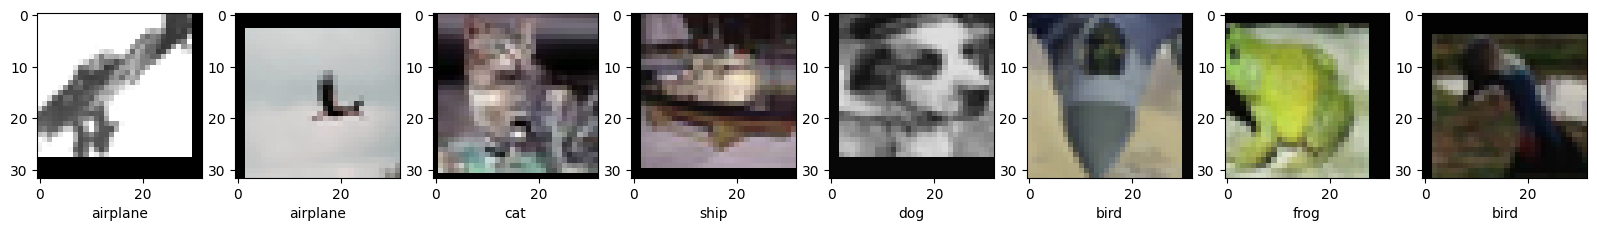

In [10]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'airplane',
     1: 'automobile',
     2: 'bird',
     3: 'cat',
     4: 'deer',
     5: 'dog',
     6: 'frog',
     7: 'horse',
     8: 'ship',
     9: 'truck'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()